In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import numpy as np
from scipy import stats
import seaborn as sns

predict = pd.read_csv('result/GAT_predicted_data.csv');
# clinical = pd.read_csv('data/clinical/TCGA-BRCA.csv');

# clinical['id_key'] = clinical.iloc[:, 0].str.extract(r'([^-]+-[^-]+)$')
predict = predict.rename(columns={predict.columns[0]: 'id_key'})

clinical_data = pd.read_csv('data/clinical/Human__TCGA_BRCA__MS__Clinical__Clinical__01_28_2016__BI__Clinical__Firehose.tsi', sep='\t')
clinical_data = clinical_data.set_index('attrib_name')
clinical_data = clinical_data.transpose()
clinical_data = clinical_data.reset_index().rename(columns={'index': 'patient_id'})

clinical_data['id_key'] = clinical_data['patient_id'].str.replace('.', '-', regex=False).replace('^TCGA\\-', '', regex=True)

# # Hiển thị dữ liệu

result = pd.merge(predict, clinical_data, on='id_key', how='left')
# result = pd.merge(predict, clinical, on='id_key', how='left')

print(result)
print(result.columns)


     id_key  predict_label    patient_id years_to_birth Tumor_purity  \
0   A1-A0SF              0  TCGA.A1.A0SF             54       0.7237   
1   A1-A0SJ              0  TCGA.A1.A0SJ             39       0.7984   
2   A1-A0SK              2  TCGA.A1.A0SK             54       0.9288   
3   A1-A0SO              2  TCGA.A1.A0SO             67       0.9325   
4   A1-A0SQ              0  TCGA.A1.A0SQ             45       0.8417   
..      ...            ...           ...            ...          ...   
63  A7-A0DC              0  TCGA.A7.A0DC             63          NaN   
64  A7-A13D              2  TCGA.A7.A13D             46       0.8612   
65  A7-A13E              2  TCGA.A7.A13E             62       0.9184   
66  A7-A26E              0  TCGA.A7.A26E             71       0.7913   
67  A7-A26G              2  TCGA.A7.A26G             50       0.5182   

   pathologic_stage pathology_T_stage pathology_N_stage pathology_M_stage  \
0           stageii                t2                n0   

In [3]:

# Convert categorical variables to numeric where needed
result['years_to_birth'] = pd.to_numeric(result['years_to_birth'], errors='coerce')
result['number_of_lymph_nodes'] = pd.to_numeric(result['number_of_lymph_nodes'], errors='coerce')

# Function to calculate p-values for different types of variables
def calculate_p_value(subtype, clinical_var):
    if clinical_var in ['years_to_birth', 'number_of_lymph_nodes']:
        # For continuous variables, use ANOVA
        groups = [group for _, group in result.groupby('predict_label')[clinical_var]]
        return stats.f_oneway(*groups)[1]
    else:
        # For categorical variables, use Chi-square test
        contingency = pd.crosstab(result['predict_label'], result[clinical_var])
        return stats.chi2_contingency(contingency)[1]

# List of clinical parameters to analyze
clinical_params = [
    'years_to_birth',  # age
    'gender',
    'pathologic_stage',
    'pathology_T_stage',  # tumor size
    'pathology_N_stage',  # lymph node status
    'pathology_M_stage'   # metastasis status
]

# Calculate p-values and -log10(p-values)
p_values = {}
log_p_values = {}
significant_params = []

for param in clinical_params:
    p_val = calculate_p_value('predict_label', param)
    p_values[param] = p_val
    log_p_values[param] = -np.log10(p_val)
    if p_val < 0.05:
        significant_params.append(param)


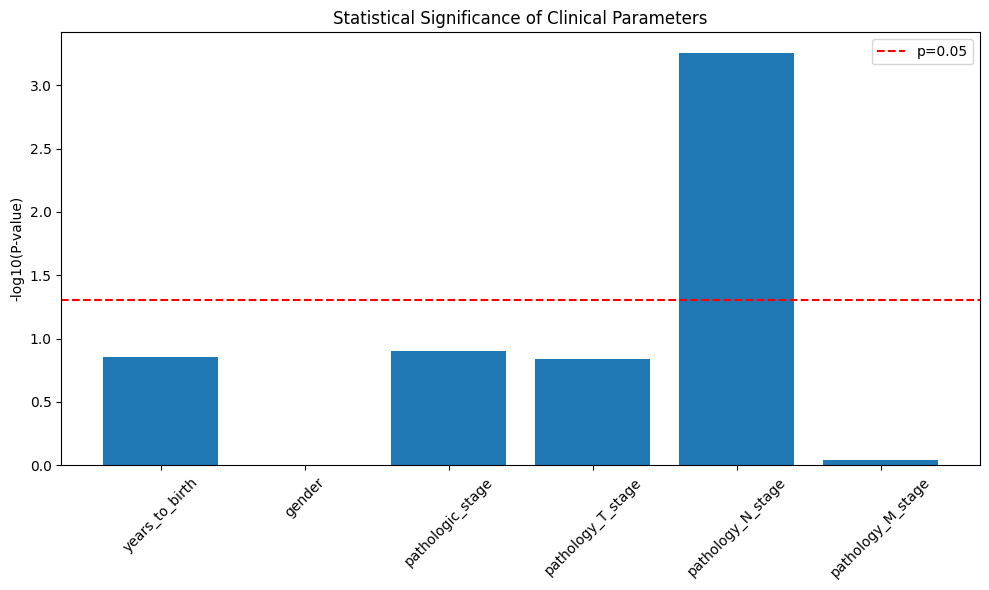

In [4]:

# Plot -log10 P-values
plt.figure(figsize=(10, 6))
plt.bar(log_p_values.keys(), log_p_values.values())
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.xticks(rotation=45)
plt.ylabel('-log10(P-value)')
plt.title('Statistical Significance of Clinical Parameters')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:

# Print results
print("\nNumber of significant clinical parameters:", len(significant_params))
print("\nSignificant parameters:", significant_params)
print("\nP-values for each parameter:")
for param, p_val in p_values.items():
    print(f"{param}: {p_val:.2e}")

# Analyze relationships between subtypes and clinical features
print("\nSubtype Analysis:")
for param in clinical_params:
    if param in ['years_to_birth', 'number_of_lymph_nodes']:
        print(f"\n{param} by subtype:")
        print(result.groupby('predict_label')[param].describe())
    else:
        print(f"\n{param} distribution by subtype:")
        print(pd.crosstab(result['predict_label'], result[param]))

# Save results to CSV
result.to_csv('clinical_analysis_results.csv', index=False)



Number of significant clinical parameters: 1

Significant parameters: ['pathology_N_stage']

P-values for each parameter:
years_to_birth: 1.39e-01
gender: 1.00e+00
pathologic_stage: 1.26e-01
pathology_T_stage: 1.45e-01
pathology_N_stage: 5.56e-04
pathology_M_stage: 9.15e-01

Subtype Analysis:

years_to_birth by subtype:
               count       mean        std   min    25%   50%    75%   max
predict_label                                                             
0               36.0  59.750000  13.310307  37.0  49.75  59.5  70.25  90.0
1                7.0  48.428571  11.759495  34.0  38.00  50.0  58.50  62.0
2               22.0  55.863636  11.650855  36.0  48.00  58.0  62.00  85.0
3                3.0  52.333333   2.516611  50.0  51.00  52.0  53.50  55.0

gender distribution by subtype:
gender         female
predict_label        
0                  36
1                   7
2                  22
3                   3

pathologic_stage distribution by subtype:
pathologic_stage  s

In [6]:
print(result.columns)


Index(['id_key', 'predict_label', 'patient_id', 'years_to_birth',
       'Tumor_purity', 'pathologic_stage', 'pathology_T_stage',
       'pathology_N_stage', 'pathology_M_stage', 'histological_type',
       'number_of_lymph_nodes', 'PAM50', 'ER.Status', 'PR.Status',
       'HER2.Status', 'gender', 'radiation_therapy', 'race', 'ethnicity',
       'Median_overall_survival', 'overall_survival', 'status',
       'overallsurvival'],
      dtype='object')


C:\Users\haitd02\AppData\Local\Temp\ipykernel_21140\2189473324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = df['overallsurvival'].str.replace(',', '.')
C:\Users\haitd02\AppData\Local\Temp\ipykernel_21140\2189473324.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = df['overallsurvival'].astype(float)
C:\Users\haitd02\AppData\Local\Temp\ipykernel_21140\2189473324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

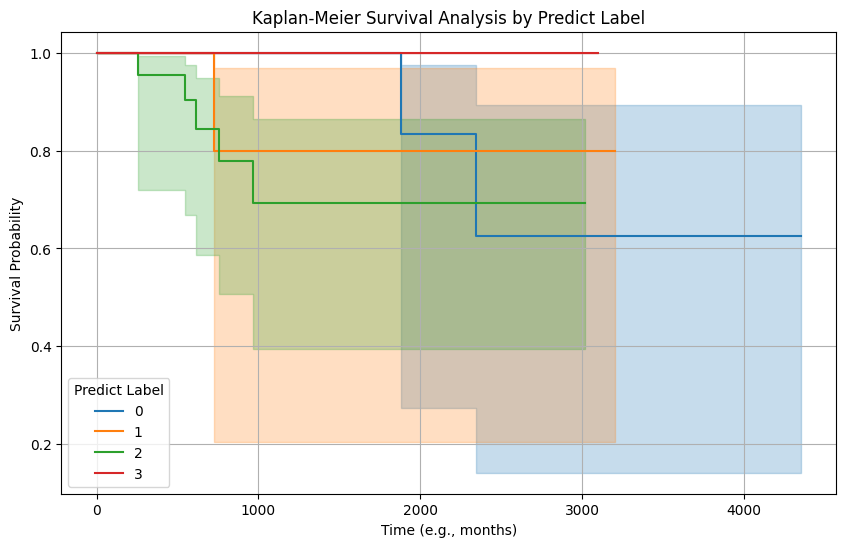

In [9]:
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']]


# Làm sạch dữ liệu: chuyển dấu ',' thành '.' và ép kiểu sang float
df['overallsurvival'] = df['overallsurvival'].str.replace(',', '.')
df['overallsurvival'] = df['overallsurvival'].astype(float)

# Nếu status cũng không phải số, thì ép kiểu:
df['status'] = df['status'].astype(int)


from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

# Vẽ theo từng nhóm predict_label
for label, grouped_df in df.groupby('predict_label'):
    kmf.fit(durations=grouped_df['overallsurvival'],
            event_observed=grouped_df['status'],
            label=str(label))
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Analysis by Predict Label")
plt.xlabel("Time (e.g., months)")
plt.ylabel("Survival Probability")
plt.legend(title="Predict Label")
plt.grid(True)
plt.show()


C:\Users\haitd02\AppData\Local\Temp\ipykernel_21140\2480426510.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['overallsurvival'] = df['overallsurvival'].str.replace(',', '.').astype(float)


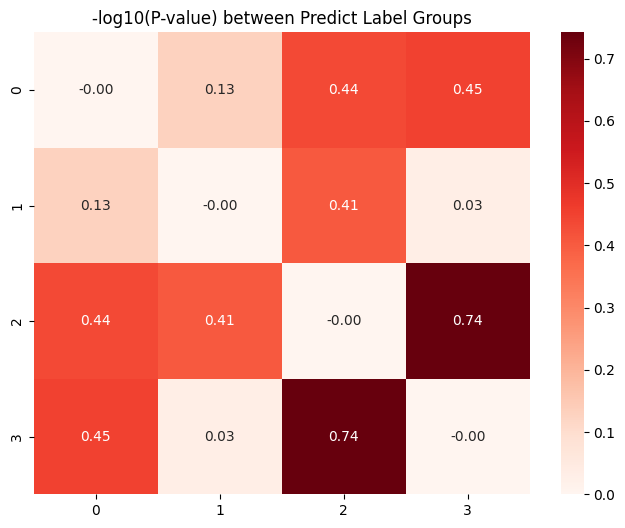

In [16]:
from lifelines.statistics import pairwise_logrank_test
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử df là dataframe của bạn
df = result[['overallsurvival', 'status', 'predict_label', 'id_key']]

# Chuyển đổi cột 'overallsurvival' thành số (thay dấu phẩy thành dấu chấm)
df['overallsurvival'] = df['overallsurvival'].str.replace(',', '.').astype(float)

# Tính p-values giữa các nhóm
results = pairwise_logrank_test(df['overallsurvival'], df['predict_label'], df['status'])

# Lấy danh sách nhãn
labels = sorted(df['predict_label'].unique())

# Tạo ma trận rỗng cho p-value
p_matrix = pd.DataFrame(np.ones((len(labels), len(labels))), index=labels, columns=labels)

# Điền các p-value vào ma trận
p_values = results.p_value  # Đây là mảng một chiều
k = 0  # Biến để theo dõi chỉ mục trong mảng p_values
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        p = p_values[k]  # Truy xuất p-value theo chỉ mục k
        p_matrix.loc[labels[i], labels[j]] = p
        p_matrix.loc[labels[j], labels[i]] = p
        k += 1  # Tăng chỉ mục để lấy p-value tiếp theo

# Tính –log10(P) để làm rõ sự khác biệt
log_p = -np.log10(p_matrix)

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(log_p, annot=True, cmap="Reds", fmt=".2f")
plt.title("-log10(P-value) between Predict Label Groups")
plt.show()


In [17]:
import pandas as pd
from scipy.stats import chi2_contingency, pearsonr

# Correlation for continuous variables
continuous_cols = ['Tumor_purity', 'years_to_birth', 'number_of_lymph_nodes']
for col in continuous_cols:
    corr, _ = pearsonr(df[col], df['predict_label'])
    print(f'Correlation between {col} and predict_label: {corr}')

# Chi-squared test for categorical variables
categorical_cols = ['ER.Status', 'PR.Status', 'HER2.Status', 'gender', 'race', 'ethnicity']
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['predict_label'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f'Chi-squared test for {col}: p-value = {p}')


KeyError: 'Tumor_purity'